# "Ranking learning"

- toc: false
- comments: true
- hide: true
- search_exclude: true

So we have some kind of reading club at our company where we normally share papers that we find interesting, so one of us has to explain the paper to the rest. 
This is week was my turn and since we had lately been talking about recommendation I thought on looking for a paper on Ranking. But instead of finding a SOA paper,
I thought it might be interesting to go into the roots and start simple since I hadnt touched much about this topic before. I finally decided to talk about the 
paper by Microsoft named "" wchich is not precisely new. Once I started reading it some references to previous work pop out as expected but there was a common term in 
all of them, a more basic concept named Ordinal Regression. So I decided to read about this and explain this concept before commenting on the paper. So I am gonna 
recreate my talk here starting from Ordinal Regression and touching later on Ranking as explained in the Microsoft paper. 

So to clarify, Ordinal regression is actually the same as Ranking Learning only that the latter is used in the machine learning field. The authors in the paper mention Ordinal Regression itself as a model and I think what they really refer to is the generalized linear model that I will present next (actually Wikipedia will).

Wikipedia has a nice entry on this topic so I am just going to copy the relevant parts and comment them when needed:

## Linear models for ordinal regression
Ordinal regression can be performed using a generalized linear model (GLM) that fits both a coefficient vector and a set of thresholds to a dataset. Suppose one has a set of observations, represented by length-p vectors $\small x_1$ through $\small x_n$, with associated responses $\small y_1$ through $\small y_n$, where each $\small y_i$ is an ordinal variable on a scale $\small 1, ..., K$. For simplicity, and without loss of generality, we assume $\small y$ is a non-decreasing vector, that is, $\small y_i \leq y_{i+1}$. To this data, one fits a length-p coefficient vector $\small \bf w$ and a set of thresholds $\small \theta_1, ..., \theta_{K−1}$ with the property that $\small θ1 < \theta_2 < ... < \theta_{K−1}$. This set of thresholds divides the real number line into $\small K$ disjoint segments, corresponding to the $\small K$ response levels.
The model can now be formulated as 
$$
\large Pr(y\leq i|\bf{x}) = \sigma(\theta_i - \bf{w \cdot x})
$$

There are different options for the $\small\sigma$ function (inverse link funciton in GLM language) which is our cummulative distribution function, and I am going to mention two:
- logistic function
- probit function

When we use the logistic function we assume that our error term follows a logistic distribution with $\small \mu = 0$ and $s = 0$ (scale parameter) conditioned on $\small \bf{x}$ and when we use the probit function we assume our error term follows a normal distribution with $\small \mu = 0$ and $\small \sigma = 0$ conditioned on $\small \bf{x}$. Both distributions have a similar shape but the logistic distribution has heavier tails, hence being more robust.

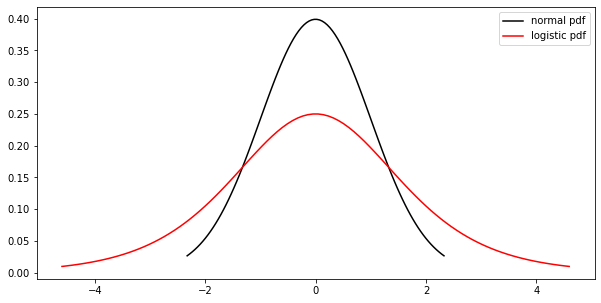

In [26]:
import numpy as np
from scipy.stats import norm, logistic

import matplotlib.pyplot as plt

loc = 0
scale = 1
# generate points to plot normal distribution
x_norm = np.linspace(norm.ppf(0.01, loc, scale), norm.ppf(0.99, loc, scale), 100)
y_norm = norm.pdf(x_norm)

# generate points to plot logistic distribution
x_logistic = np.linspace(logistic.ppf(0.01, loc, scale), logistic.ppf(0.99, loc, scale), 100)
y_logistic = logistic.pdf(x_logistic)

plt.figure(figsize=(10,5))
plt.plot(x_norm, y_norm, color='k', label='normal pdf')
plt.plot(x_logistic, y_logistic, color='r', label='logistic pdf')
plt.legend();


So maybe you are still wondering where this error term appears or how do we even fit this model, so the wikipedia article goes on and introduces the latent variable model. 

## Latent variable model
The probit version of the above model can be justified by assuming the existence of a real-valued latent variable (unobserved quantity) $\small y*$, determined by
$$
\large y* = \bf{w\cdot x} + \epsilon
$$
where the error term is normally distributed conditioned on $\small x$ (as mentioned above). The response variable $\small y$ results from an "incomplete measurement" of $\small y*$, where one only determines the interval into which $\small y*$ falls:
$$
\large 
y =
    \begin{cases}
      1 & \text{if $y* \leq \theta_1$}\\
      2 & \text{if $\theta_1 \leq y* \leq \theta_2$}\\
      \vdots\\
      K & \text{if $\theta_{k-1} \leq y*$}
    \end{cases}  
$$

So from this definition the conditional distribution of $\small y$ can be derived as 
$$
\begin{align}
\large P(y = k|x) & = P(\theta_{k-1} \leq y* \leq \theta_k|\bf{x})\\
\large            & = P(\theta_{k-1} \leq \bf{w \cdot x + \epsilon} \leq \theta_k)\\
\large            & = P(\theta_{k-1} - \bf{w \cdot x} \leq \epsilon  \leq \theta_k - \bf{w \cdot x})\\
\large            & =  \phi(\theta_{k} - \bf{w \cdot x}) - \phi(\theta_{k-1} - \bf{w \cdot x})
\end{align}
$$

So now that we have the conditional distribution of $\small y$ we can derive the likelihood function for a single training example:
$$
\large log \mathcal{L}(\bf{w}, \theta|\bf{x}_i, y_i) = \sum_{k=1}^{k}[y_i = k]\cdot log(\phi(\theta_k - \bf{w \cdot x}_i) - \phi(\theta_{k-1} - \bf{w \cdot x}_i))
$$

So now that we know the model and understand it, let's see an example. Statsmodels has this model implemented in the V0.13.0.dev0 version so if you want to give it a try you will have to install from their github (link) until they put this version in the Pypi indices or conda channels.

In [23]:
import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel

import seaborn as sns

In [17]:
abalone_data = pd.read_csv('abalone.csv')
abalone_data.response = pd.Categorical(abalone_data.response, ordered=True)

In [18]:
abalone_data.head()

,response,V2,V3,V4,V5,V6,V7,V8
0,8,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,4,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,5,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [19]:
mod_prob = OrderedModel(abalone_data['response'],
                        abalone_data[abalone_data.columns[1:]],
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.648141
         Iterations: 101
         Function evaluations: 102
         Gradient evaluations: 102


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               response   Log-Likelihood:                -6884.3
Model:                   OrderedModel   AIC:                         1.380e+04
Method:            Maximum Likelihood   BIC:                         1.389e+04
Date:                Fri, 16 Apr 2021                                         
Time:                        16:34:43                                         
No. Observations:                4177                                         
Df Residuals:                    4163                                         
Df Model:                          14                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V2             0.6831      0.879      0.777      0.437      -1.040       2.406
V3             7.9829      1.075      7.423      0.000       5.875      10.091
V4             5.7866      0.728      7.945      0.000       4.359       7.214
V5             3.0927      0.368      8.413      0.000       2.372       3.813
V6            -8.2448      0.423    -19.495      0.000      -9.074      -7.416
V7            -2.6864      0.632     -4.254      0.000      -3.924      -1.449
V8             3.9445      0.586      6.736      0.000       2.797       5.092
1/2            2.4488      0.150     16.331      0.000       2.155       2.743
2/3           -0.3241      0.046     -7.042      0.000      -0.414      -0.234
3/4           -0.3365      0.038     -8.841      0.000      -0.411      -0.262
4/5           -0.3961      0.034    -11.500      0.000      -0.464      -0.329
5/6           -0.5378      0.036    -14.828      0.000      -0.609      -0.467
6/7           -0.7116      0.042    -16.964      0.000      -0.794      -0.629
7/8           -0.4531      0.043    -10.635      0.000      -0.537      -0.370
==============================================================================
"""

In [20]:
num_of_thresholds = 7
thresholds = mod_prob.transform_threshold_params(res_prob.params[-num_of_thresholds:])#[1:num_of_thresholds + 1]
coefficients = [0.6831, 7.9829, 5.7866, 3.0927, -8.2448, -2.6864, 3.9445]

In [21]:
row = np.random.randint(0, abalone_data.shape[0])
predicted_label = res_prob.predict(abalone_data.iloc[row: row+1, [1,2,3,4,5,6,7]]).values.argmax() + 1
mean_i = np.dot(coefficients, abalone_data.iloc[row, [1,2,3,4,5,6,7]].values)
true_label = abalone_data.loc[row, 'response']
print(f'row: {row} \npredicted_label: {predicted_label} \ntrue_label: {true_label}')

row: 564 
predicted_label: 4 
true_label: 8


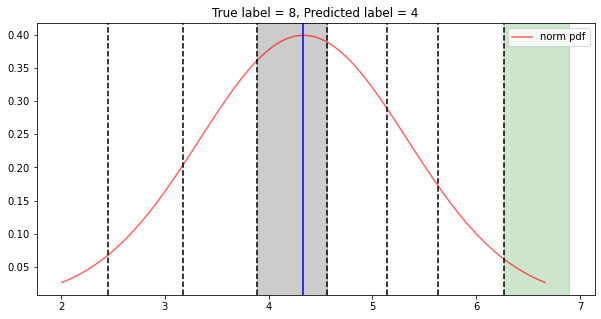

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
x = np.linspace(norm.ppf(0.01, loc=mean_i),
                norm.ppf(0.99, loc=mean_i), 100)
sns.lineplot(x=x, y=norm.pdf(x, loc=mean_i),color='r', alpha=0.6, label='norm pdf')
plt.axvline(mean_i, color='b')

index = np.where(thresholds<mean_i)[0][-1]

if thresholds[predicted_label] == np.inf:
    plt.axvspan(thresholds[predicted_label - 1], ax.get_xlim()[1], alpha=0.2, color='k')
elif thresholds[predicted_label - 1] == -np.inf:
    plt.axvspan(ax.get_xlim()[0], thresholds[predicted_label], alpha=0.2, color='k')
else:
    plt.axvspan(thresholds[predicted_label - 1], thresholds[predicted_label], alpha=0.2, color='k')

if thresholds[true_label] == np.inf:
    plt.axvspan(thresholds[true_label - 1], ax.get_xlim()[1], alpha=0.2, color='g')
elif thresholds[true_label - 1] == -np.inf:
    plt.axvspan(ax.get_xlim()[0], thresholds[true_label], alpha=0.2, color='g')
else:
    plt.axvspan(thresholds[true_label - 1], thresholds[true_label], alpha=0.2, color='g')
for th in thresholds:
    ax.axvline(th, 0, color='k', linestyle='--')
    
plt.title(f'True label = {true_label}, Predicted label = {predicted_label}');

## Ranking Learning

So now we are turning to the paper by Microsoft and try to explain it a little bit. I will focus mostly on the things I found more interesting so feel free to check the paper for more information.